<a href="https://colab.research.google.com/github/osamja/zero-to-hero/blob/main/lecture_3/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

- Cheatsheet: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb


In [3]:
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt    # Uncomment to download names.txt
names = open('names.txt', 'r').read().splitlines()

In [4]:
# Create a dictionary of characters and their indices
chars = sorted(list(set(''.join(names))))
char2idx = {c: i+1 for i, c in enumerate(chars)}
idx2char = {i+1: c for i, c in enumerate(chars)}

char2idx['.'] = 0  # ? andrej has this set to zero but doesn't that replace the first character in the alphabet?
idx2char[0] = '.'

In [5]:
# Build the dataset
block_size = 3 # context length: how many characters to consider before predicting the next character
X, Y = [], []

for name in names[:1]:
    name = name + '.'
    context = [0] * block_size      # The first context is a block of zeros which enables padding
    for c in name:
        X.append(context)
        Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
        # print(''.join([idx2char[i] for i in context]), '->', c)
        context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
        
X = torch.tensor(X, dtype=torch.long)   # Should we be using long or ints?
Y = torch.tensor(Y, dtype=torch.long)

num_examples = X.shape[0]
print('Number of examples:', num_examples)

Number of examples: 5


In [6]:
# Embed the characters
x_enc = torch.nn.functional.one_hot(X, num_classes=27).float()
x_enc.shape

C = torch.randn((27, 2))    # Two dimensional embedding
C[5] == F.one_hot(torch.tensor(5), num_classes=27).float() @ C


tensor([True, True])

In [7]:
# wow this array indexing is so cool
emb = C[X]
emb.shape

torch.Size([5, 3, 2])

In [8]:
emb[2][2]

tensor([-0.3776,  1.2012])

In [9]:
# construct the hidden layer
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [10]:
res = emb.reshape(5, 6)
res

tensor([[ 2.5143,  0.8726,  2.5143,  0.8726,  2.5143,  0.8726],
        [ 2.5143,  0.8726,  2.5143,  0.8726, -0.3633,  0.5824],
        [ 2.5143,  0.8726, -0.3633,  0.5824, -0.3776,  1.2012],
        [-0.3633,  0.5824, -0.3776,  1.2012, -0.3776,  1.2012],
        [-0.3776,  1.2012, -0.3776,  1.2012, -0.3825,  0.7859]])

In [11]:
emb.view(5, 6)

tensor([[ 2.5143,  0.8726,  2.5143,  0.8726,  2.5143,  0.8726],
        [ 2.5143,  0.8726,  2.5143,  0.8726, -0.3633,  0.5824],
        [ 2.5143,  0.8726, -0.3633,  0.5824, -0.3776,  1.2012],
        [-0.3633,  0.5824, -0.3776,  1.2012, -0.3776,  1.2012],
        [-0.3776,  1.2012, -0.3776,  1.2012, -0.3825,  0.7859]])

In [12]:
# -1 means "whatever is needed to make the shape work"- copilot. haha same as num_examples
emb.view(-1, 6) == emb.reshape(num_examples, 6) 

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [13]:
# calculate the hidden layer
h = emb.view(5, 6) @ W1 + b1
h = torch.tanh(h)
h.min(), h.max()

(tensor(-1.), tensor(1.))

In [14]:
# create the output layer
W2 = torch.randn(100, 27)
b2 = torch.randn(27) 

logits = h @ W2 + b2

In [15]:
logits.shape

torch.Size([5, 27])

In [16]:
# Let's get our fake counts and then normalize them into a probability distribution
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape, prob.sum(1)

(torch.Size([5, 27]), tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

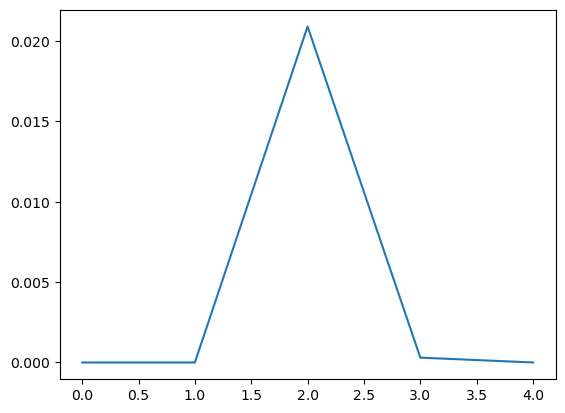

In [17]:
# Lets use y to get the actual probability
pr_dist = prob[torch.arange(num_examples), Y]
plt.plot(pr_dist)

In [18]:
# Now we can calculate the loss
loss = -torch.log(pr_dist).mean()
loss

tensor(15.2148)

In [19]:
F.cross_entropy(logits, Y)  # This is the same as the above

tensor(15.2148)

In [20]:
# Train the model from scratch
weights = None

In [21]:
 # Create a function to train the model
def train(names, weights=[], lr=0.1, epochs=1000, batch_size=32):
    loss_counts = []
    num_names = len(names)
    
    # Keep track of the learning rates
    # lre = torch.linspace(-3, 0, epochs)
    # lrs = 10 ** lre
    # learning_rates = []

    # Create a dictionary of characters and their indices
    chars = sorted(list(set(''.join(names))))
    char2idx = {c: i+1 for i, c in enumerate(chars)}
    idx2char = {i+1: c for i, c in enumerate(chars)}
    char2idx['.'] = 0  # ? andrej has this set to zero but doesn't that replace the first character in the alphabet?
    idx2char[0] = '.'

    # Build the dataset
    
    block_size = 3 # context length: how many characters to consider before predicting the next character
    X, Y = [], []

    for name in names[:num_names]:
        name = name + '.'
        context = [0] * block_size      # The first context is a block of zeros which enables padding
        for c in name:
            X.append(context)
            Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
            # print(''.join([idx2char[i] for i in context]), '->', c)
            context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
            
    X = torch.tensor(X, dtype=torch.long)   # Should we be using long or ints?
    Y = torch.tensor(Y, dtype=torch.long)

    # Create weights if they don't exist
    if len(weights) == 0:
        # Embed the characters
        C = torch.randn((27, 2))    # Two dimensional embedding
        emb = C[X]

        # construct the hidden layer
        W1 = torch.randn(6, 100)
        b1 = torch.randn(100)

        # construct the output layer
        W2 = torch.randn(100, 27)
        b2 = torch.randn(27) 
    else:   # Otherwise use the weights that were passed in
        C, W1, b1, W2, b2 = weights

    # Set the parameters to require gradients
    parameters = [W1, b1, W2, b2, C]
    for p in parameters:
        p.requires_grad = True
    
    # Forward pass
    for epoch in range(epochs):
        # lr = lrs[epoch]
        # Get a random batch of names
        # learning_rates.append(lre[epoch])
        rand_batch_idx = torch.randint(0, num_names, (batch_size,))
        x_batch = X[rand_batch_idx]
        y_batch = Y[rand_batch_idx]

        # Embed the characters
        emb = C[x_batch]
        emb = emb.view(batch_size, 6)

        # Calculate the hidden layer
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2

        # Calculate the loss
        loss = F.cross_entropy(logits, y_batch)
        loss_counts.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        with torch.no_grad():
            W1 -= lr * W1.grad
            b1 -= lr * b1.grad
            W2 -= lr * W2.grad
            b2 -= lr * b2.grad
            C -= lr * C.grad
            
        # Zero the gradients
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        C.grad.zero_()
        
        if epoch == 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')

    # Calculate the number of parameters
    batch_parameters = [W1, b1, W2, b2, emb]
    num_parameters = 0
    for p in batch_parameters:
        for s in p.shape:
            num_parameters += s
    print('Number of parameters:', num_parameters)

    # Plot the learning rates
    # plt.plot(learning_rates, loss_counts)
    # plt.xlabel('Learning rate')
    # plt.ylabel('Loss')
    # plt.title(f'Loss over learning rate')
    # plt.show()


    # Plot the loss
    plt.plot(loss_counts)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over time')
    plt.annotate(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}', (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

    # Return the trained parameter weighst
    return [C, W1, b1, W2, b2]



Number of parameters: 398


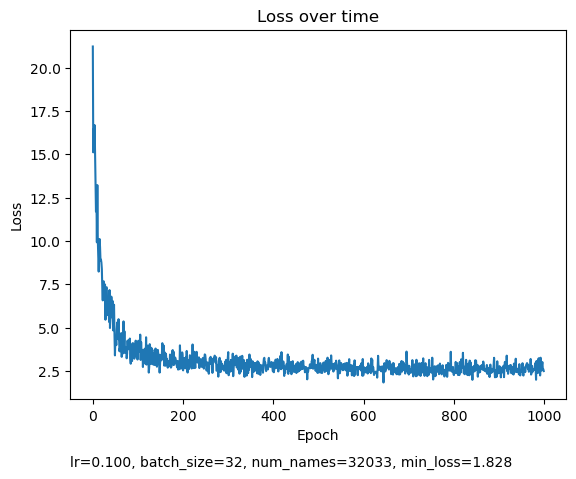

In [22]:
names = open('names.txt', 'r').read().splitlines()
weights = train(names)

Number of parameters: 398


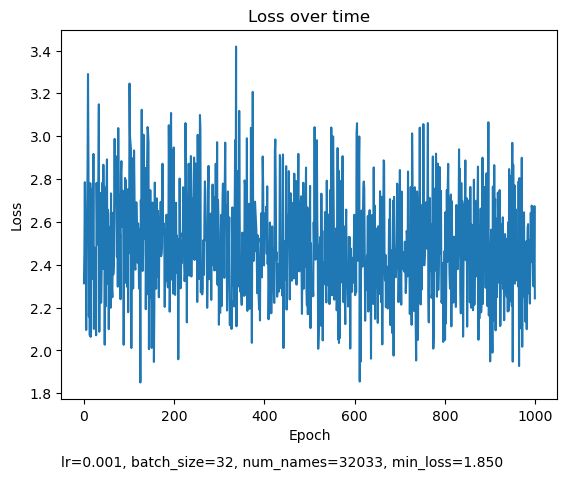

In [23]:
weights = train(names, weights=weights, lr=0.001, epochs=1000, batch_size=32)

In [24]:
[C, W1, b1, W2, b2] = weights
C.shape

torch.Size([27, 2])

In [25]:
# Sample from the model
def sample(C, W1, b1, W2, b2, num_names=10):
    context = [0] * 3
    block_size = 3
    generated_names = []
    K = 9
    layer_size = K * block_size
    for i in range(num_names):
        # Sample a name from the starting context character (.)
        context = [0] * block_size
        emb = C[context]
        name = ''
        while True:
            # Embed the characters
            emb = C[context]
            emb = emb.view(-1, layer_size)

            # Calculate the hidden layer
            h = torch.tanh(emb @ W1 + b1)
            logits = h @ W2 + b2

            # Sample from the output layer
            probs = logits.exp() / logits.exp().sum()
            idx = torch.multinomial(probs, 1)

            # Check if we're done
            if idx2char[idx.item()] == '.':
                generated_names.append(name)
                break

            # Add the character to the name
            name += (idx2char[idx.item()])

            # Update the context
            context = context[1:] + [idx.item()]
    
    return generated_names

sample(C, W1, b1, W2, b2)

RuntimeError: shape '[-1, 27]' is invalid for input of size 6

### Sample names
```
['ezyon',
 'sareroe',
 'voe',
 'japoyn',
 'belhe',
 'nna',
 'egefe',
 'calin',
 'kazec',
 'cein']
```

These names are 'name like' but I would've expected slightly better given we've traind on three context charactesr.

- To counteract a model that is overfitted to our data, we can create a train, validation/dev, and test split.

In [ ]:
# create the training, validation, and test sets
names = open('names.txt', 'r').read().splitlines()
num_names = len(names)
# shuffle the names
import random
random.shuffle(names)
num_train = int(num_names * 0.8)
num_val = int(num_names * 0.1)
num_test = num_names - num_train - num_val

train_names = names[:num_train]
val_names = names[num_train:num_train+num_val]
test_names = names[num_train+num_val:]




: 

In [ ]:
# Train the model
weights = train(train_names, lr=0.1, epochs=1000, batch_size=32)

# Sample from the model
generated_names = sample(*weights, num_names=10)

# Print the generated names
print('Generated names:')
for name in generated_names:
    print(name)

: 

In [ ]:
# Calculate the accuracy on the validation set
[C, W1, b1, W2, b2] = weights
correct = 0
total = 0

x,y = [], []
for name in train_names:
    # Convert the name to a tensor
    # Build the dataset
    block_size = 3 # context length: how many characters to consider before predicting the next character
    name = name + '.'
    context = [0] * block_size      # The first context is a block of zeros which enables padding

    for c in name:
        x.append(context)
        y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
        context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
            
x = torch.tensor(x, dtype=torch.long)   # Should we be using long or ints?
y = torch.tensor(y, dtype=torch.long)

# Embed the characters
emb = C[x]
emb = emb.view(-1, 6)

# Calculate the hidden layer
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2

# Calculate the loss
loss = F.cross_entropy(logits, y)

print('Loss:', loss.item())

# Calculate the accuracy
probs = logits.exp() / logits.exp().sum()
idx = torch.argmax(probs, 1)

correct += (idx == y).sum().item()
total += len(y)

print('x:', x)
print('y:', y)
print('idx:', idx)


print('Accuracy:', correct / total)


: 

Our loss for the train, validation, and test sets are so close that our model is actually underfitting.  To counteract this, we can expand our neural network to overit our model to our training data.

In [ ]:
 # Create a function to train the model
def train(names=train_names, weights=[], lr=0.1, epochs=10000, batch_size=64):
    loss_counts = []
    num_names = len(names)

    # Create a dictionary of characters and their indices
    chars = sorted(list(set(''.join(names))))
    char2idx = {c: i+1 for i, c in enumerate(chars)}
    idx2char = {i+1: c for i, c in enumerate(chars)}
    char2idx['.'] = 0
    idx2char[0] = '.'

    # Build the dataset
    block_size = 3 # context length: how many characters to consider before predicting the next character
    X, Y = [], []

    for name in names[:num_names]:
        name = name + '.'
        context = [0] * block_size      # The first context is a block of zeros which enables padding
        for c in name:
            X.append(context)
            Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
            context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
            
    X = torch.tensor(X, dtype=torch.long)   # Should we be using long or ints?
    Y = torch.tensor(Y, dtype=torch.long)

    # Create weights if they don't exist
    if len(weights) == 0:
        # Embed the characters
        C = torch.randn((27, 2))    # Two dimensional embedding
        emb = C[X]

        # construct the hidden layer
        W1 = torch.randn(6, 1000)
        b1 = torch.randn(1000)

        # construct the output layer
        W2 = torch.randn(1000, 27)
        b2 = torch.randn(27) 
    else:   # Otherwise use the weights that were passed in
        C, W1, b1, W2, b2 = weights

    # Set the parameters to require gradients
    parameters = [W1, b1, W2, b2, C]
    for p in parameters:
        p.requires_grad = True
    
    # Forward pass
    for epoch in range(epochs):
        rand_batch_idx = torch.randint(0, num_names, (batch_size,))
        x_batch = X[rand_batch_idx]
        y_batch = Y[rand_batch_idx]

        # Embed the characters
        emb = C[x_batch]
        emb = emb.view(-1, 6)

        # Calculate the hidden layer
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2

        # Calculate the loss
        loss = F.cross_entropy(logits, y_batch)
        loss_counts.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        with torch.no_grad():
            W1 -= lr * W1.grad
            b1 -= lr * b1.grad
            W2 -= lr * W2.grad
            b2 -= lr * b2.grad
            C -= lr * C.grad
            
        # Zero the gradients
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        C.grad.zero_()
        
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')

    # Plot the loss
    plt.plot(loss_counts)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over time')
    plt.annotate(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}', (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

    # Return the trained parameter weighst
    return [C, W1, b1, W2, b2]

weights = train()

: 

In [187]:
val_losses = []

# Exercises:
- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

### Exercise 1: 
- Tune the hyperparameters of the training to beat my best validation loss of 2.2

In [197]:
# create the training, validation, and test sets
names = open('names.txt', 'r').read().splitlines()
num_names = len(names)
# shuffle the names
import random
random.shuffle(names)
num_train = int(num_names * 0.8)
num_val = int(num_names * 0.1)
num_test = num_names - num_train - num_val

train_names = names[:num_train]
val_names = names[num_train:num_train+num_val]
test_names = names[num_train+num_val:]

# Train the model with different hyperparameters
# lrs = [0.1, 0.01, 0.001, 0.0001]
# batch_sizes = [64, 128, 256, 512]

# embedding size: how many dimensions to embed the characters into

ch_emb_sizes = [4]
neuron_sizes = [200]
second_neuron_size = 100
block_sizes = [4] # context length: how many characters to consider before predicting the next character
num_epoch_sizes = [50000]


 # Create a function to train the model
def train(names=train_names, weights=[], lr=0.1, batch_size=32):
    loss_counts = []
    num_names = len(names)

    # Create a dictionary of characters and their indices
    chars = sorted(list(set(''.join(names))))
    char2idx = {c: i+1 for i, c in enumerate(chars)}
    idx2char = {i+1: c for i, c in enumerate(chars)}
    char2idx['.'] = 0
    idx2char[0] = '.'

    tuned_weights = []

    epoch_counts = []

    for K in ch_emb_sizes:
        for neurons in neuron_sizes:
            for block_size in block_sizes:
                for epochs in num_epoch_sizes:
                    lr = 0.1
                    # Build the dataset
                    X, Y = [], []

                    for name in names[:num_names]:
                        name = name + '.'
                        context = [0] * block_size      # The first context is a block of zeros which enables padding
                        for c in name:
                            X.append(context)
                            Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
                            context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
                            
                    X = torch.tensor(X, dtype=torch.long)
                    Y = torch.tensor(Y, dtype=torch.long)

                    num_epochs = epochs
                    adjustment_epoch = num_epochs // 2

                    # print('epochs:', epochs)
                    # print('adjustment_epoch:', adjustment_epoch)

                    layer_size = K * block_size # MOVE BELOW


                    # Embed the characters
                    C = torch.randn((27, K))    # Two dimensional embedding -> 3D -> 
                    emb = C[X]

                    # construct the first hidden layer
                    W1 = torch.randn(layer_size, neurons)
                    b1 = torch.randn(neurons)

                    # construct the second hidden layer
                    W2 = torch.randn(neurons, second_neuron_size)
                    b2 = torch.randn(second_neuron_size)

                    # construct the output layer
                    W3 = torch.randn(second_neuron_size, 27)
                    b3 = torch.randn(27) 

                    # Set the parameters to require gradients
                    parameters = [W1, b1, W2, b2, W3, b3, C]
                    for p in parameters:
                        p.requires_grad = True
                    
                    # Forward pass
                    for epoch in range(epochs):
                        epoch_counts.append(epoch)
                        # Tune the learning rate and batch size
                        if epoch == adjustment_epoch:
                            lr = lr / 10
                        # if epoch == adjustment_epoch + adjustment_epoch // 2:
                        #     lr = lr / 10
                            # batch_size = batch_size * 2
                            # print(f'Adjusting learning rate to {lr} and batch size to {batch_size} at epoch {epoch}.')
                        # elif epoch < adjustment_epoch and lr <= 0.01:
                        #     lr = lr * 10
                        #     # print(f'Adjusting learning rate to {lr} and batch size to {batch_size} at epoch {epoch}.')

                        rand_batch_idx = torch.randint(0, num_names, (batch_size,))
                        x_batch = X[rand_batch_idx]
                        y_batch = Y[rand_batch_idx]

                        # Embed the characters
                        emb = C[x_batch]
                        emb = emb.view(-1, layer_size)

                        # Calculate the first hidden layer
                        h1 = emb @ W1 + b1
                        h2 = torch.tanh(h1 @ W2 + b2)
                        logits = h2 @ W3 + b3

                        # Calculate the loss
                        loss = F.cross_entropy(logits, y_batch)
                        loss_counts.append(loss.item())
                        
                        # Backward pass
                        loss.backward()
                        
                        # Update the weights
                        with torch.no_grad():
                            W1 -= lr * W1.grad
                            b1 -= lr * b1.grad
                            W2 -= lr * W2.grad
                            b2 -= lr * b2.grad
                            W3 -= lr * W3.grad
                            b3 -= lr * b3.grad
                            C -= lr * C.grad
                            
                        # Zero the gradients
                        W1.grad.zero_()
                        b1.grad.zero_()
                        W2.grad.zero_()
                        b2.grad.zero_()
                        W3.grad.zero_()
                        b3.grad.zero_()
                        C.grad.zero_()
                        
                        # if epoch % 1000 == 0:
                        #     print(f'Epoch: {epoch}, Loss: {loss.item()}')

                    print(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}, K={K}, neurons={neurons}, block_size={block_size}, epochs={epochs}')
                    tuned_weights.append([C, W1, b1, W2, b2, W3, b3, K, neurons, second_neuron_size, block_size, epochs, min(loss_counts)])

    # Plot the loss
    plt.plot(loss_counts)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over time')
    plt.annotate(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}', (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

    # Return the trained parameter weighst
    return tuned_weights

tuned_weights = train()

In [ ]:
# Evaluate the hopefully overfitted model
def evaluate(names, hyperparams):
    C, W1, b1, W2, b2, W3, b3, K, neurons, second_neuron_size, block_size, epochs, min_loss = hyperparams
    num_names = len(names)

    # Build the dataset
    X, Y = [], []

    for name in names[:num_names]:
        name = name + '.'
        context = [0] * block_size      # The first context is a block of zeros which enables padding
        for c in name:
            X.append(context)
            Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
            context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
            
    X = torch.tensor(X, dtype=torch.long)   # Should we be using long or ints?
    Y = torch.tensor(Y, dtype=torch.long)

    layer_size = K * block_size

    # Embed the characters
    emb = C[X]
    emb = emb.view(-1, layer_size)
    h = emb @ W1 + b1
    h = torch.tanh(h @ W2 + b2)
    logits = h @ W3 + b3

    # Calculate the loss
    loss = F.cross_entropy(logits, Y)
    
    return loss.item(), K, neurons, second_neuron_size, block_size, epochs, min_loss

for hyperparams in tuned_weights:
    val_loss_params = evaluate(val_names, hyperparams)
    val_losses.append(val_loss_params)
    print(f'val_loss_params: {val_loss_params}')

    train_loss_params = evaluate(train_names, hyperparams)
    print(f'train_loss_params: {train_loss_params}\n')


val_loss_params: (2.50475811958313, 3, 400, 100, 4, 50000, 1.7651023864746094)
train_loss_params: (2.5015368461608887, 3, 400, 100, 4, 50000, 1.7651023864746094)



In [ ]:
for val_loss in val_losses:
    print(val_loss)

(2.8731911182403564, 3, 400, 200, 4, 5000, 1.984777808189392)
(2.838102102279663, 3, 400, 200, 4, 5000, 2.314951181411743)
(2.6811134815216064, 3, 400, 200, 4, 15000, 2.0333564281463623)
(2.50475811958313, 3, 400, 100, 4, 50000, 1.7651023864746094)


In [38]:
# Sample from the model
def sample(C, W1, b1, W2, b2,  num_names=10):
    context = [0] * block_size
    generated_names = []
    
    for i in range(num_names):
        # Sample a name from the starting context character (.)
        context = [0] * block_size
        emb = C[context]
        name = ''
        while True:
            # Embed the characters
            emb = C[context]
            emb = emb.view(-1, layer_size)

            # Calculate the hidden layer
            h = torch.tanh(emb @ W1 + b1)
            logits = h @ W2 + b2

            # Sample from the output layer
            probs = logits.exp() / logits.exp().sum()
            idx = torch.multinomial(probs, 1)

            # Check if we're done
            if idx2char[idx.item()] == '.':
                generated_names.append(name)
                break

            # Add the character to the name
            name += (idx2char[idx.item()])

            # Update the context
            context = context[1:] + [idx.item()]
    
    return generated_names

In [41]:
# Sample from the model
ex_weights = tuned_weights[0]
print('Example weights:', ex_weights)
generated_names = sample(*ex_weights, num_names=10)

# Print the generated names
print('Generated names:')
for name in generated_names:
    print(name)

Example weights: [tensor([[-1.6151,  0.4331, -0.2931],
        [-0.0288, -0.2700,  0.3360],
        [-0.1532,  0.1982,  0.2513],
        [ 0.1888,  0.2084,  0.2760],
        [ 0.0315,  0.1771,  0.0886],
        [-0.0284, -0.3845,  0.0920],
        [-0.0046,  0.1789,  0.1480],
        [ 0.0892,  0.0763,  0.2648],
        [ 0.3877,  0.2708, -0.0433],
        [ 0.1860, -0.3919, -0.0546],
        [ 0.1825,  0.1706, -0.1213],
        [ 0.1735,  0.2874,  0.1056],
        [ 0.0434,  0.4218, -0.1677],
        [ 0.2854,  0.3064, -0.1072],
        [ 0.2205, -0.0062, -0.2922],
        [ 0.1468, -0.3178,  0.2880],
        [ 0.0231,  0.2422,  0.2512],
        [ 0.4479,  0.2504, -1.1159],
        [ 0.0418,  0.1297, -0.1864],
        [ 0.1742,  0.1809,  0.2244],
        [ 0.0820,  0.2657,  0.2408],
        [ 0.1387, -0.3843,  0.1501],
        [ 0.1739,  0.2783, -0.0999],
        [ 0.1886,  0.1990, -0.0924],
        [ 0.2329,  0.0265,  0.0213],
        [ 0.3216, -0.1348, -0.0443],
        [ 0.2302,  0

TypeError: sample() got multiple values for argument 'num_names'

: 

The best I was able to do was 
- loss.item(), K, neurons, block_size, epochs, min_loss
- (2.350400924682617, 3, 1000, 4, 50000, 1.205239176750183)
- (2.30, 3, 500, 4, 40000, 1.384570837020874)
- (2.296140193939209, 3, 800, 4, 50000, 1.3054497241973877)
